# Методы оптимизации
## Лабораторная работа 1: Методы градиентного спуска и метод Ньютона.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
import scipy
from scipy.sparse import diags

from oracles import QuadraticOracle, LogRegL2Oracle, create_log_reg_oracle
from oracles import grad_finite_diff, hess_finite_diff
from plot_trajectory_2d import plot_levels, plot_trajectory
from optimization import LineSearchTool, get_line_search_tool, gradient_descent, newton

sns.set_theme()

In [2]:
# Функция для отрисовки линий уровня функции и траектории сходимости
def plot_func_levels_and_trajectory(oracle, history, title, xrange=None, yrange=None, levels=None):
  plot_levels(oracle.func, xrange=xrange, yrange=yrange, levels=levels);
  plot_trajectory(oracle.func, history['x']);
  plt.title(title);
  plt.grid();

# Функция для отрисовки изменения значения функции во времени
def plot_func_value_at_time(oracles, history, labels, w0_point, dataset_name):
  fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True);
  fig.suptitle(f'Минимизация функции потерь логистической функции \n датасет {dataset_name}')

  for i in range(len(history)):
    axes[0].plot(history[i]['time'], history[i]['func'], label=labels[i])
    axes[0].set_xlabel('Время, с')
    axes[0].set_ylabel('f(x)')
    axes[0].legend()

  for i in range(len(history)):
    grads_history = np.array(history[i]['grad_norm'])
    init_grad = np.linalg.norm(oracles[i].grad(w0_point))
    axes[1].plot(history[i]['time'], grads_history**2 / init_grad**2, label=labels[i])
    axes[1].set_xlabel('Время, с')
    axes[1].set_ylabel('$|∇f(x)|^2/|∇f(x_0)|^2$')
    axes[1].legend()

# Эксперимент подсчета кол-ва итераций в зависимости от числа обусловленности
def get_iter_of_cond_df(oracle, line_search_options, method="GD", display=False):
  methods = {"GD": gradient_descent, "Newton": newton}
  df = pd.DataFrame(data={'dimension': [], 'iterations': [], 'condition': []})
  n = np.array([10**i for i in range(1,5)], dtype=np.int_)
  k = np.arange(1, 500, 10)
  iterations = []

  for ni in n:
    x0 = np.random.randn(ni)
    for ki in k:
      ki_iterations = []
      for _ in range(5):
        if ki != 1:
          diagonal = np.random.randint(1, ki, (ni, )) + np.random.random((ni, ))
          diagonal[0] = 1
          diagonal[-1] = ki
          A = diags(diagonal, 0)
        else:
          A = np.eye(ni)
        b = np.random.randint(-10, 10, size=(ni,))

        oracle = QuadraticOracle(A, b)
        x_opt, message, history = methods[method](oracle, x0, tolerance=1e-9, line_search_options=line_search_options, trace=True, display=display)
        ki_iterations.append(len(history['time']))

      dfi = pd.DataFrame(data={'dimension': ni,
                              'iterations': ki_iterations,
                              'condition': ki})
      df = pd.concat([df, dfi], axis=0)
  return df

# Эксперимент подсчета невязки в лог.шкале в зависимости от номера итерации
def get_residual_of_iter_df(oracle, x0_points, method="GD"):
  methods = {"GD": gradient_descent, "Newton": newton}
  df1 = pd.DataFrame({'strategy': [],'iterations': [], 'residual': []})
  df2 = pd.DataFrame({'strategy': [],'iterations': [], 'residual': []})
  df = [df1, df2]

  for i in range(len(x0_points)):
    for c in [0.025, 0.01]:
      x_opt, _, history = methods[method](oracle, x0_points[i], line_search_options={'method': 'Constant', 'c': c}, trace=True)
      df_i = pd.DataFrame(data={'strategy': f'Constant, c: {c}',
                              'iterations': range(1, len(history['x']) + 1),
                              'residual': np.log(np.abs((oracle.func(x_opt) - history['func'])/oracle.func(x_opt)))})
      df[i] = pd.concat([df[i], df_i], axis=0)

    for c1 in [1e-3, 1e-4, 1e-5]:
      x_opt, _, history = methods[method](oracle, x0_points[i], line_search_options={'method': 'Armijo', 'c1': c1}, trace=True)
      df_i = pd.DataFrame(data={'strategy': f'Armijo, c1: {c1}',
                              'iterations': range(1, len(history['x']) + 1),
                              'residual': np.log(np.abs((oracle.func(x_opt) - history['func'])/oracle.func(x_opt)))})
      df[i] = pd.concat([df[i], df_i], axis=0)

    for c2 in [0.9, 0.1, 0.01]:
      x_opt, _, history = methods[method](oracle, x0_points[i], line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': c2}, trace=True)
      df_i = pd.DataFrame(data={'strategy': f'Wolfe, c1: {1e-4}, c2: {c2}',
                              'iterations': range(1, len(history['x']) + 1),
                              'residual': np.log(np.abs((oracle.func(x_opt) - history['func'])/oracle.func(x_opt)))})
      df[i] = pd.concat([df[i], df_i], axis=0)

    df[i] = df[i].reset_index()
  return df


# Эксперимент оптимизации лосс-функцией лог.регрессии на реальных данных
def get_opt_history_on_real_data(file_name, method='GD'):
  print(f'{get_opt_history_on_real_data.__name__}: function started...')
  methods = {'GD': gradient_descent, 'Newton': newton}

  print(f"{get_opt_history_on_real_data.__name__}: '{file_name}' is proceeding...")
  X, y = load_svmlight_file(file_name)
  regcoef = 1 / X.shape[0]
  w0_point = np.zeros(X.shape[1])
  oracle = create_log_reg_oracle(X, y, regcoef, oracle_type='usual')

  w_opt, _, history = methods[method](oracle, w0_point, trace=True)

  return oracle, w0_point, w_opt, history

## 1. Основные задачи


1. Реализовать метод градиентного спуска \
Проверка работы на квадратичной функции:

In [3]:
oracle = QuadraticOracle(np.eye(5), np.arange(5))

In [4]:
x_opt1, message1, history1 = gradient_descent(oracle, np.random.randn(5), line_search_options={'method': 'Constant', 'c': 0.005}, trace=True)
x_opt2, message2, history2 = gradient_descent(oracle, np.random.randn(5), line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)
x_opt3, message3, history3 = gradient_descent(oracle, np.random.randn(5), line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9}, trace=True)

print('Found optimal point: {}'.format(x_opt1))
print('Found optimal point: {}'.format(x_opt2))
print('Found optimal point: {}'.format(x_opt3))

Found optimal point: [3.93708102e-03 9.95999781e-01 1.99814801e+00 2.99229345e+00
 3.98847938e+00]
Found optimal point: [0. 1. 2. 3. 4.]
Found optimal point: [0. 1. 2. 3. 4.]


2. Получить формулы для функции потерь лог.регрессии, его градиента и гессиана в матрично-векторном виде (см. документ `Отчет.DOCX`);
3. Реализовать оракул функции потерь лог.регрессии (см. файл `oracles.py`);
4. Реализовать подсчет разностных производных. Проверить правильность реализации
подсчета градиента и гессиана логистического оракула.

In [5]:
n = 100
regcoef = 0.001

x1 = np.random.normal(0, 1, (n, 2))
b1 = np.ones(n)

x2 = np.random.normal(5, 2, (n, 2))
b2 = (-1) * np.ones(n)

A = np.vstack([x1, x2])
b = np.hstack([b1, b2])

df = pd.DataFrame({'x1': A[:, 0],
                  'x2': A[:, 1],
                  'class': b}).reset_index()

In [6]:
oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')
x_points = [np.array([10, 10]), np.array([-20, -30]), np.array([0, 0]), np.array([1, 2])]

In [7]:
for x in x_points:
  print("Точка", x)
  print("------"*10)
  print("Аналитическая производная\n", oracle.grad(x), "\nРазностная производная\n", grad_finite_diff(oracle.func, x))
  print("------"*10)
  print("Аналитический гессиан\n", oracle.hess(x).toarray(), "\nРазностный гессиан\n", hess_finite_diff(oracle.func, x))
  print()

Точка [10 10]
------------------------------------------------------------
Аналитическая производная
 [2.50971025 2.664666  ] 
Разностная производная
 [2.50971084 2.66466671]
------------------------------------------------------------
Аналитический гессиан
 [[ 0.00753291 -0.00644127]
 [-0.00644127  0.00769146]] 
Разностный гессиан
 [[ 0.0074607  -0.00653699]
 [-0.00653699  0.00774492]]

Точка [-20 -30]
------------------------------------------------------------
Аналитическая производная
 [-0.14426258 -0.17968748] 
Разностная производная
 [-0.14426256 -0.17968746]
------------------------------------------------------------
Аналитический гессиан
 [[ 0.01240959 -0.00754003]
 [-0.00754003  0.00600515]] 
Разностный гессиан
 [[ 0.01239009 -0.00752287]
 [-0.00752287  0.00603961]]

Точка [0 0]
------------------------------------------------------------
Аналитическая производная
 [1.17130548 1.26612465] 
Разностная производная
 [1.1713055  1.26612468]
---------------------------------------

5. Реализовать метод Ньютона.\
Проверка работы на квадратичной функции:



In [8]:
oracle = QuadraticOracle(np.eye(5), np.arange(5))

In [9]:
x_opt1, message1, history1 = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1}, trace=True)
x_opt2, message2, history2 = newton(oracle, np.zeros(5), line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)
x_opt3, message3, history3 = newton(oracle, np.zeros(5), line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9}, trace=True)

print('Found optimal point: {}'.format(x_opt1))
print('Found optimal point: {}'.format(x_opt2))
print('Found optimal point: {}'.format(x_opt3))

Found optimal point: [0. 1. 2. 3. 4.]
Found optimal point: [0. 1. 2. 3. 4.]
Found optimal point: [0. 1. 2. 3. 4.]


## 2. Эксперименты

### 2.1. Эксперимент: Траектория градиентного спуска на квадратичной функции

In [10]:
np.random.seed(0)

#### Зависимость от числа обусловленности

In [11]:
oracles = []
x_opts = []
messages = []
histories = []

for _ in range(2):
  u = np.triu(np.random.randint(-10, 10, size=(2, 2)))
  A = u.dot(u.T)
  b = np.random.randint(-10, 10, size=(2,))
  oracle = QuadraticOracle(A, b)
  x_opt, message, history = gradient_descent(oracle, np.random.randn(2), line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)

  oracles.append(oracle)
  x_opts.append(x_opt)
  messages.append(message)
  histories.append(history)

/content/plot_trajectory_2d.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0);


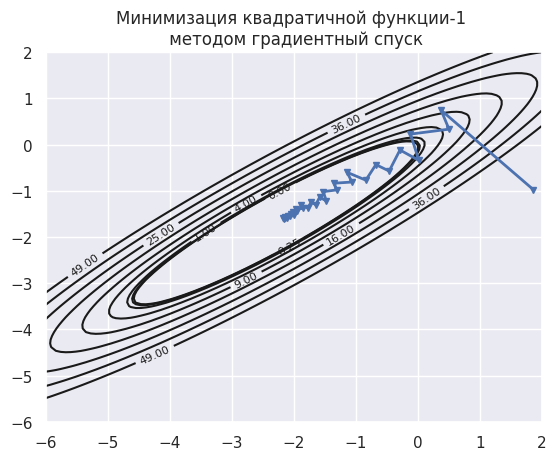

In [12]:
plot_func_levels_and_trajectory(oracles[0], histories[0],
          title="Минимизация квадратичной функции-1 \n методом градиентный спуск",
          xrange=[-6, 2], yrange=[-6, 2],
          levels=[0, 0.25, 1, 4, 9, 16, 25, 36, 49])

In [13]:
print('Число обусловленности:', np.linalg.cond(oracles[0].A))
print('Количество итераций:', len(histories[0]['x']))

Число обусловленности: 29.006341106221335
Количество итераций: 33


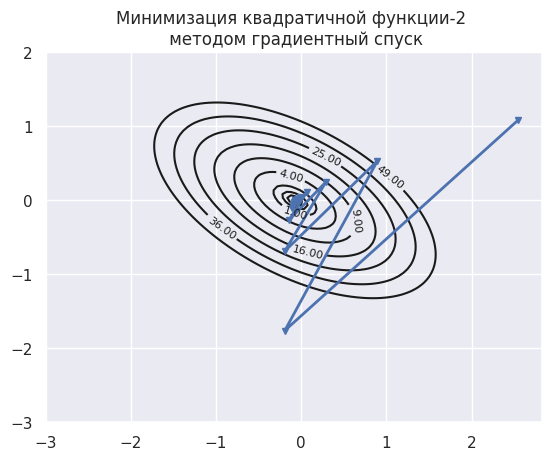

In [14]:
plot_func_levels_and_trajectory(oracles[1], histories[1],
          title="Минимизация квадратичной функции-2 \n методом градиентный спуск",
          xrange=[-3, 2], yrange=[-3, 2],
          levels=[0, 0.25, 1, 4, 9, 16, 25, 36, 49])

In [15]:
print('Число обусловленности:', np.linalg.cond(oracles[1].A))
print('Количество итераций:', len(histories[1]['x']))

Число обусловленности: 3.803253801956947
Количество итераций: 15


#### Зависимость от начальной точки
Возьмем первую квадратичную функцию.

In [16]:
oracle = oracles[0]

In [17]:
x_opt1, message1, history1 = gradient_descent(oracle, [-2.5, -0.5], line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)
x_opt2, message2, history2 = gradient_descent(oracle, np.array([1, 0.5]), line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)

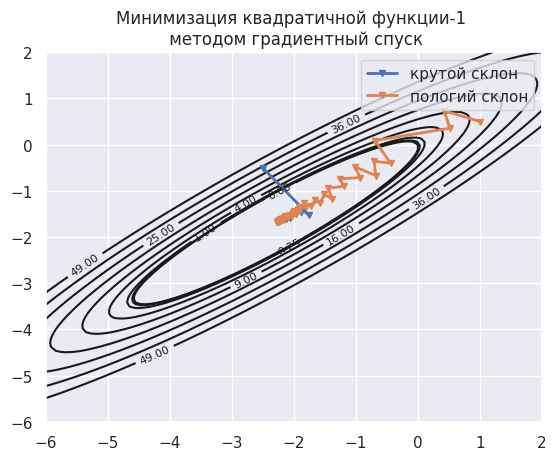

In [18]:
plot_levels(oracle.func, xrange=[-6, 2], yrange=[-6, 2], levels=[0, 0.25, 1, 4, 9, 16, 25, 36, 49]);
plot_trajectory(oracle.func, history1['x'], label='крутой склон');
plot_trajectory(oracle.func, history2['x'], label='пологий склон');

plt.title("Минимизация квадратичной функции-1 \n методом градиентный спуск")
plt.legend()
plt.grid()

In [19]:
print('Количество итераций (крутой склон):', len(history1['x']))
print('Количество итераций (пологий склон):', len(history2['x']))

Количество итераций (крутой склон): 20
Количество итераций (пологий склон): 51


#### Зависимость от стратегии выбора шага
Возьмем первую квадратичную функцию.

In [20]:
oracle = oracles[0]

In [21]:
x_opt1, message1, history1 = gradient_descent(oracle, np.array([1, 0.5]), line_search_options={'method': 'Constant', 'c': 0.005}, trace=True)
x_opt2, message2, history2 = gradient_descent(oracle, np.array([1, 0.5]), line_search_options={'method': 'Armijo', 'c1': 1e-4}, trace=True)
x_opt3, message3, history3 = gradient_descent(oracle, np.array([1, 0.5]), line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9}, trace=True)

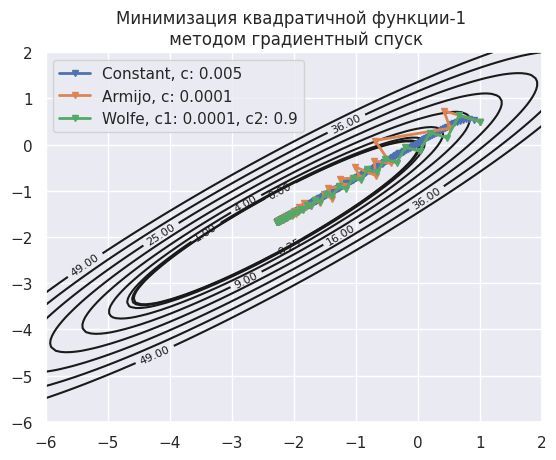

In [22]:
plot_levels(oracle.func, xrange=[-6, 2], yrange=[-6, 2], levels=[0, 0.25, 1, 4, 9, 16, 25, 36, 49])
plot_trajectory(oracle.func, history1['x'], label=f'Constant, c: {0.005}')
plot_trajectory(oracle.func, history2['x'], label=f'Armijo, c: {1e-4}')
plot_trajectory(oracle.func, history3['x'], label=f'Wolfe, c1: {1e-4}, c2: {0.9}')

plt.title("Минимизация квадратичной функции-1 \n методом градиентный спуск")
plt.legend()
plt.grid()

In [23]:
print('Количество итераций (Constant):', len(history1['x']))
print('Количество итераций (Armijo):', len(history2['x']))
print('Количество итераций (Wolfe):', len(history3['x']))

Количество итераций (Constant): 391
Количество итераций (Armijo): 51
Количество итераций (Wolfe): 50


### 2.2. Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

In [24]:
oracle = oracles[0]

In [ ]:
df_const = get_iter_of_cond_df(oracle, line_search_options={'method': 'Constant', 'c': 0.025})
df_armijo = get_iter_of_cond_df(oracle, line_search_options={'method': 'Armijo', 'c1': 1e-4})
df_wolfe = get_iter_of_cond_df(oracle, line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9})

<ipython-input-26-66da8c4bd9cf>:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(ax=axes[0], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_const);
<ipython-input-26-66da8c4bd9cf>:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(ax=axes[1], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_armijo);
<ipython-input-26-66da8c4bd9cf>:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(ax=axes[2], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_wolfe);


Text(0.5, 1.0, 'linear-search: Wolfe, c1=0.0001, c2=0.9')

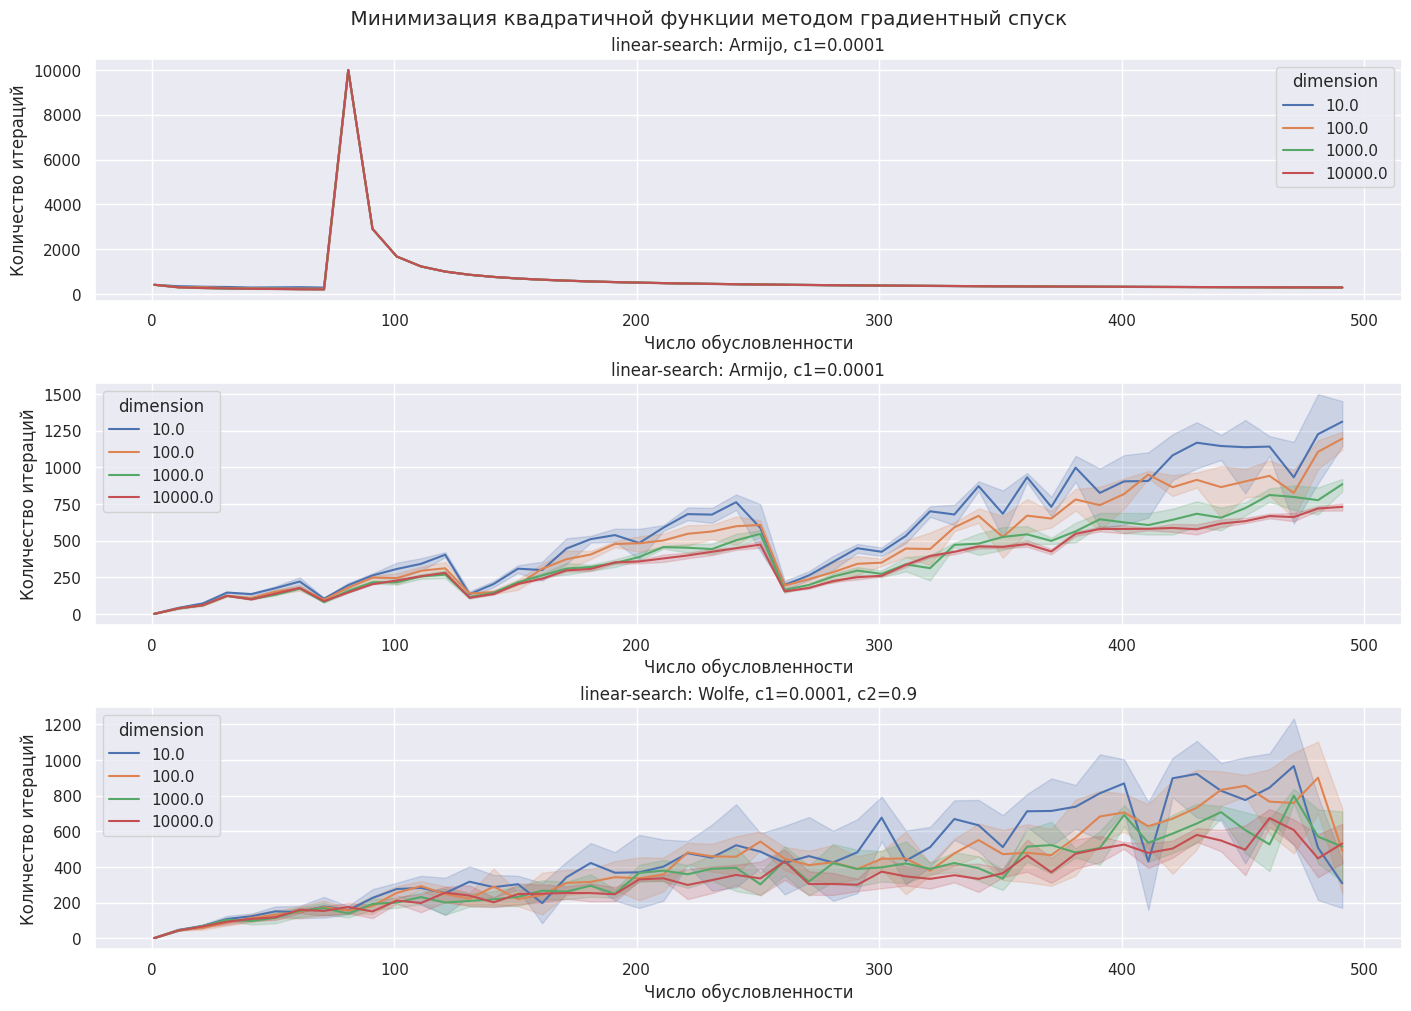

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), constrained_layout=True);
fig.suptitle(' Минимизация квадратичной функции методом градиентный спуск')

sns.lineplot(ax=axes[0], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_const);
sns.lineplot(ax=axes[1], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_armijo);
sns.lineplot(ax=axes[2], x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_wolfe);

for i in range(3):
  axes[i].set_xlabel('Число обусловленности')
  axes[i].set_ylabel('Количество итераций')

axes[0].set_title(f"linear-search: Armijo, c1={1e-4}")
axes[1].set_title(f"linear-search: Armijo, c1={1e-4}")
axes[2].set_title(f"linear-search: Wolfe, c1={1e-4}, c2={0.9}")

### 2.3. Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

In [31]:
file_paths = ['./real-sim', './w8a', './gisette_scale']
file_names = [file_path.split('/')[1] for file_path in file_paths]
labels = ['Gradient descent', 'Newton']

In [32]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[1], method='GD')
Newton_oracle, w0_point, _, Newton_history = get_opt_history_on_real_data(file_paths[1], method='Newton')
oracles = [GD_oracle, Newton_oracle]
history = [GD_history, Newton_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './w8a' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './w8a' is proceeding...


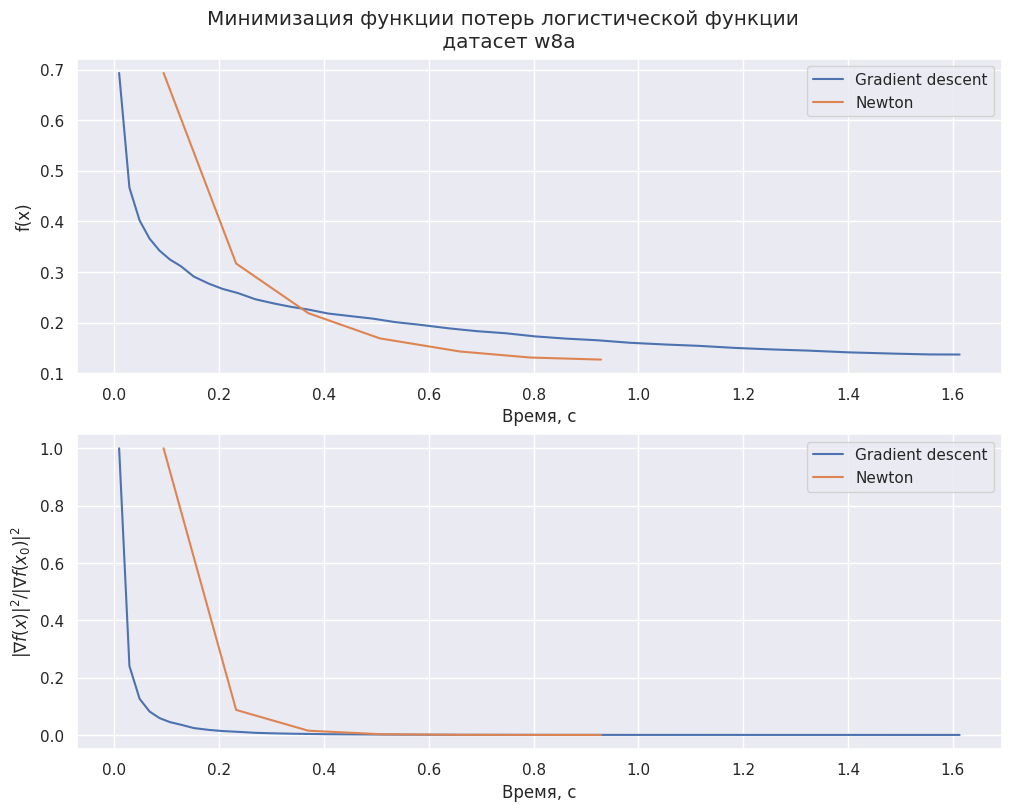

In [33]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[1])

In [34]:
del GD_history
del Newton_history

In [35]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[0], method='GD')
Newton_oracle, w0_point, _, Newton_history = get_opt_history_on_real_data(file_paths[0], method='Newton')
oracles = [GD_oracle, Newton_oracle]
history = [GD_history, Newton_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './real-sim' is proceeding...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './real-sim' is proceeding...


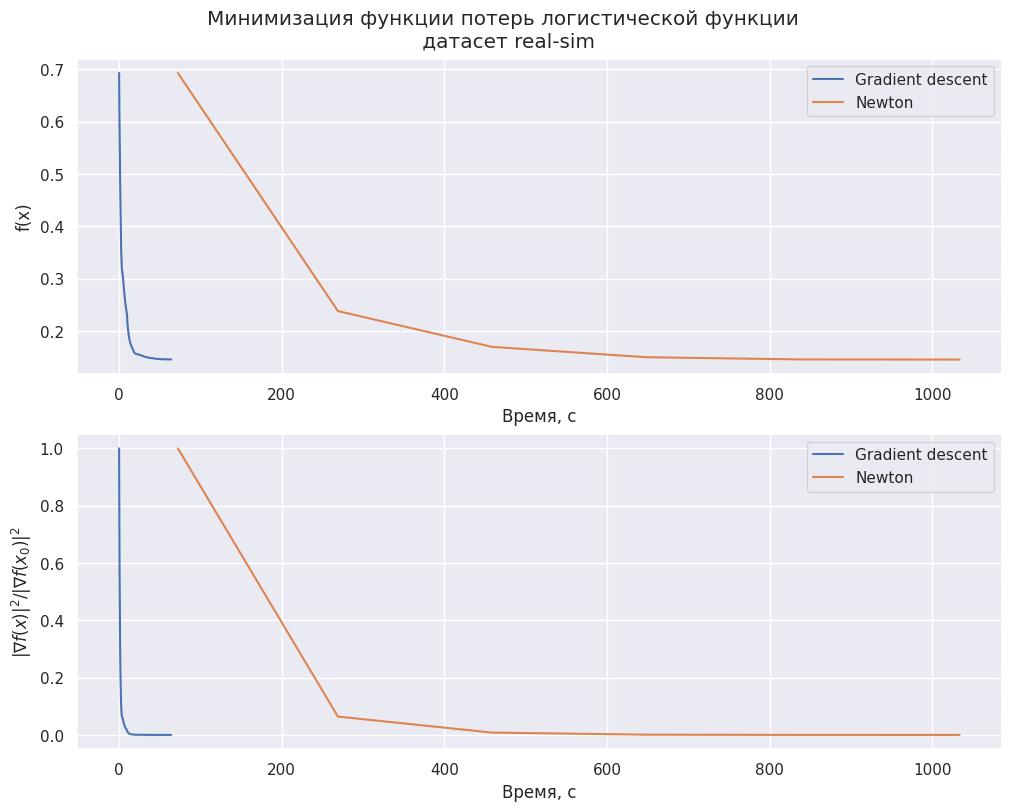

In [36]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[0])

In [37]:
del GD_history
del Newton_history

In [38]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[2], method='GD')
Newton_oracle, w0_point, _, Newton_history = get_opt_history_on_real_data(file_paths[2], method='Newton')
oracles = [GD_oracle, Newton_oracle]
history = [GD_history, Newton_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './gisette_scale' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './gisette_scale' is proceeding...


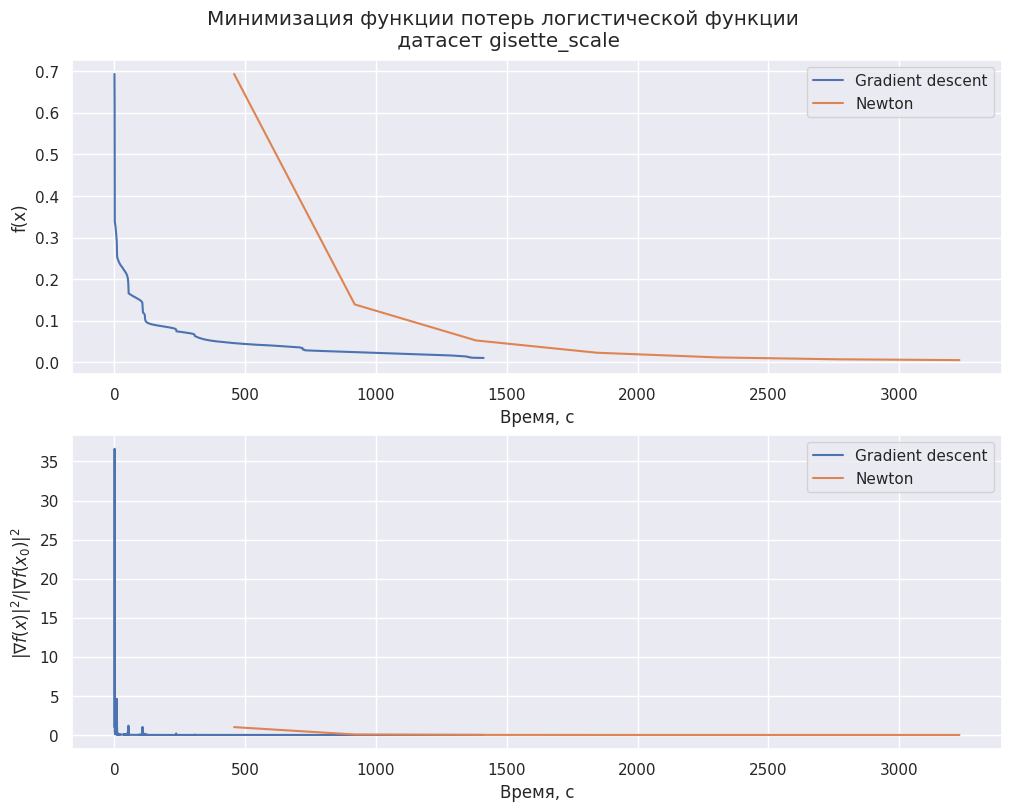

In [39]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[2])

In [40]:
del GD_history
del Newton_history

### 2.4. Эксперимент: Стратегия выбора длины шага в градиентном спуске

#### 1. Квадратичная функция
Возьмем первую квадратичную функцию.

In [27]:
oracle = oracles[0]
x0_points = [np.array([1, 0.5]), np.array([-2.5, -0.5])]

In [ ]:
df = get_residual_of_iter_df(oracle, x0_points)

<ipython-input-29-997d69797366>:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
<ipython-input-29-997d69797366>:5: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);


Text(0.5, 1.0, 'x0=[-2.5, -0.5]')

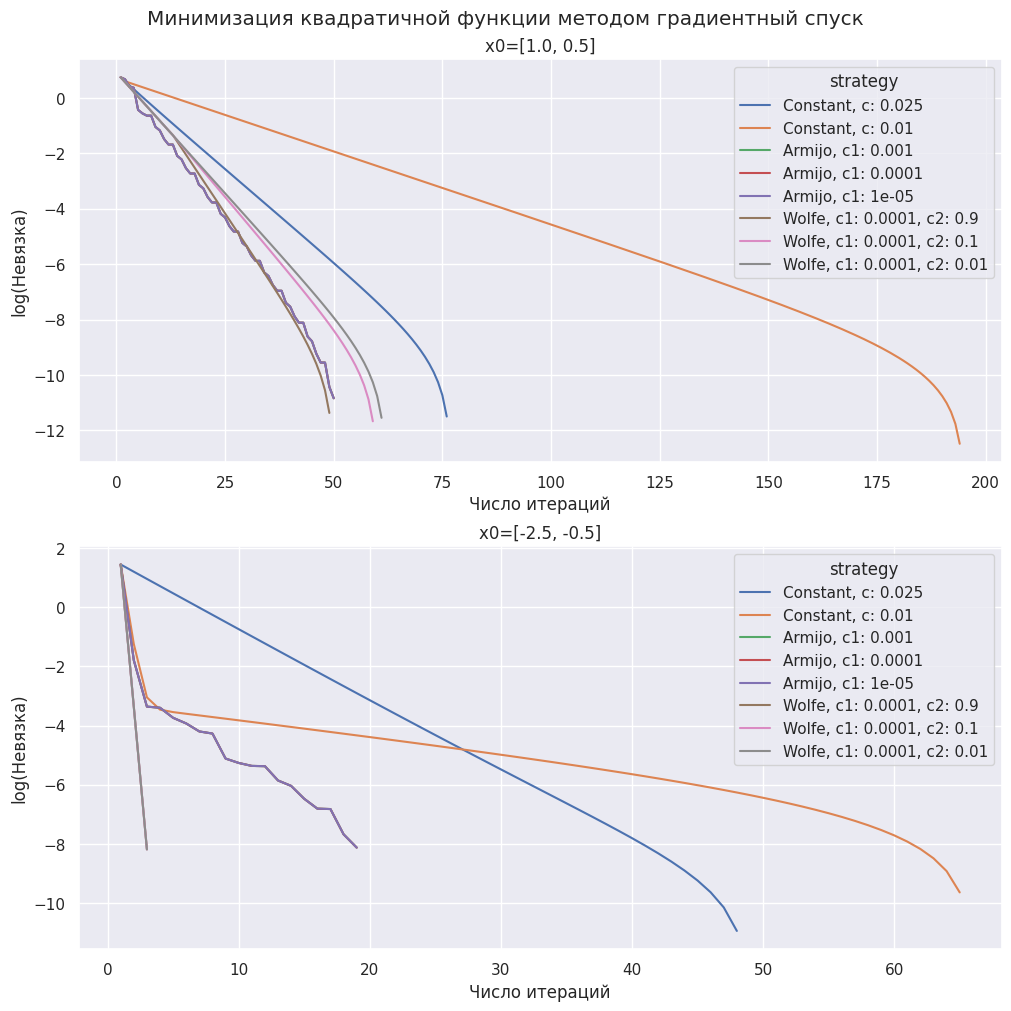

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True);
fig.suptitle('Минимизация квадратичной функции методом градиентный спуск')

sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);

for i in range(2):
  axes[i].set_xlabel('Число итераций')
  axes[i].set_ylabel('log(Невязка)')

axes[0].set_title(f"x0={list(x0_points[0])}")
axes[1].set_title(f"x0={list(x0_points[1])}")

#### 2. Логистическая регрессия

In [30]:
n = 100
regcoef = 0.001

x1 = np.random.normal(0, 1, (n, 2))
b1 = np.ones(n)

x2 = np.random.normal(5, 2, (n, 2))
b2 = (-1) * np.ones(n)

A = np.vstack([x1, x2])
b = np.hstack([b1, b2])

df = pd.DataFrame({'x1': A[:, 0],
                  'x2': A[:, 1],
                  'class': b}).reset_index()

<ipython-input-31-7340e2655b88>:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="x1", y="x2", hue='class', palette=sns.color_palette(), data=df)


Text(0, 0.5, 'a2')

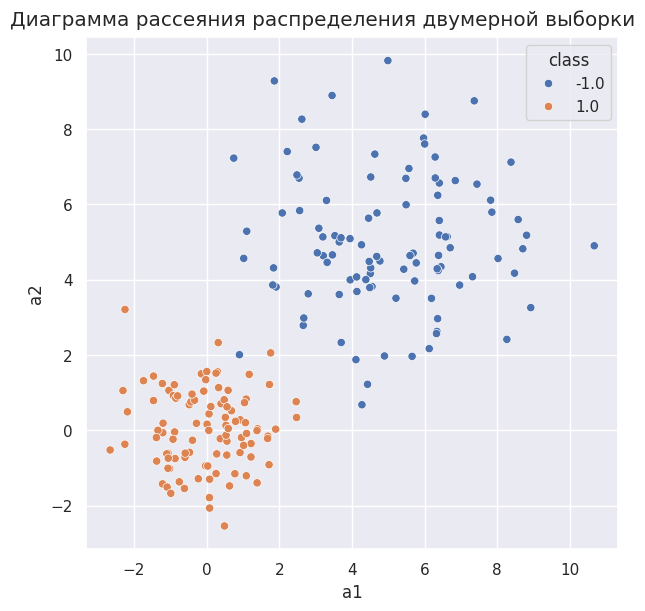

In [31]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True);
fig.suptitle('Диаграмма рассеяния распределения двумерной выборки')

sns.scatterplot(x="x1", y="x2", hue='class', palette=sns.color_palette(), data=df)

ax.set_xlabel('a1')
ax.set_ylabel('a2')

In [32]:
oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')
x0_points = [np.array([10, 10]), np.array([-20, -30])]

In [ ]:
df = get_residual_of_iter_df(oracle, x0_points)

<ipython-input-34-33c5b41c0c0c>:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
<ipython-input-34-33c5b41c0c0c>:5: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);


Text(0.5, 1.0, 'x0=[-20, -30]')

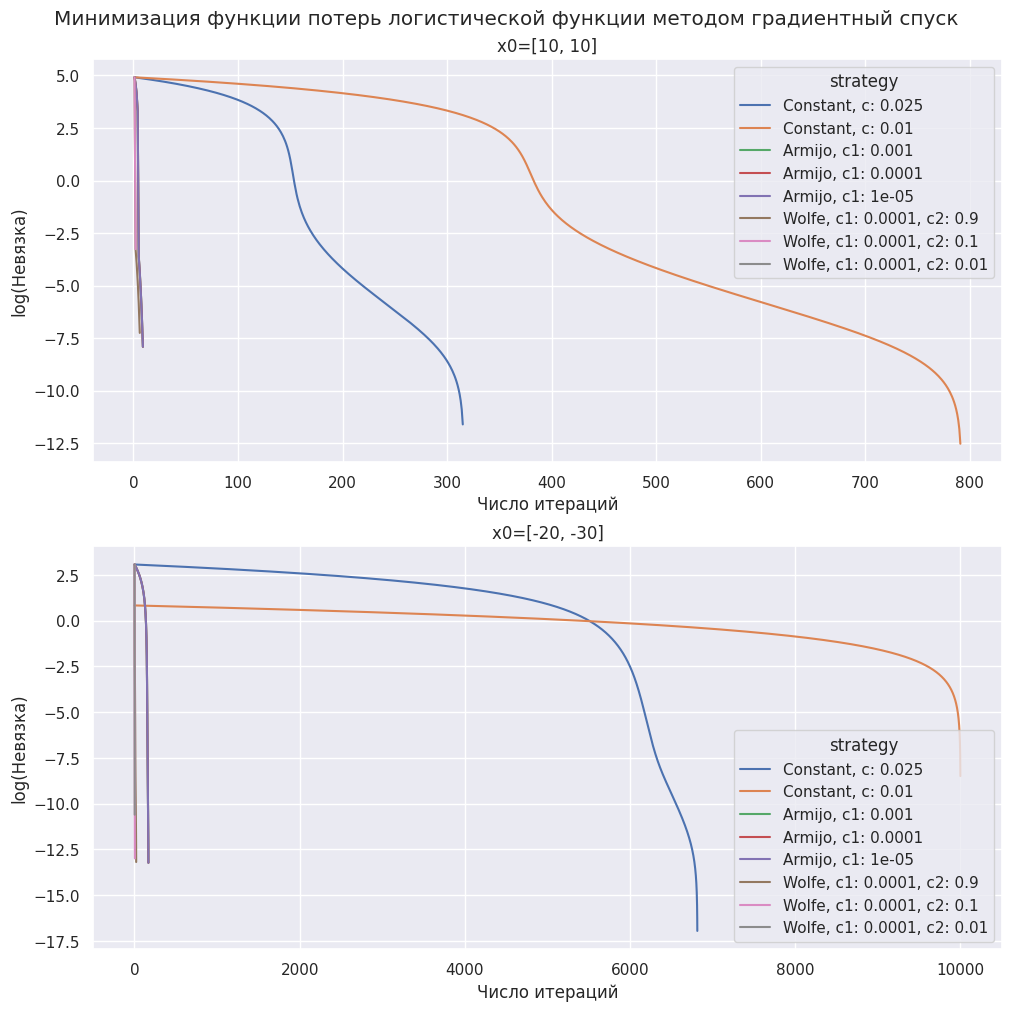

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True);
fig.suptitle('Минимизация функции потерь логистической функции методом градиентный спуск')

sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);

for i in range(2):
  axes[i].set_xlabel('Число итераций')
  axes[i].set_ylabel('log(Невязка)')

axes[0].set_title(f"x0={list(x0_points[0])}")
axes[1].set_title(f"x0={list(x0_points[1])}")

### 2.5. Эксперимент: Стратегия выбора длины шага в методе Ньютона

#### Логистическая регрессия

In [35]:
n = 100
regcoef = 0.001

x1 = np.random.normal(0, 1, (n, 2))
b1 = np.ones(n)

x2 = np.random.normal(5, 2, (n, 2))
b2 = (-1) * np.ones(n)

A = np.vstack([x1, x2])
b = np.hstack([b1, b2])

df = pd.DataFrame({'x1': A[:, 0],
                  'x2': A[:, 1],
                  'class': b}).reset_index()

<ipython-input-36-7340e2655b88>:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="x1", y="x2", hue='class', palette=sns.color_palette(), data=df)


Text(0, 0.5, 'a2')

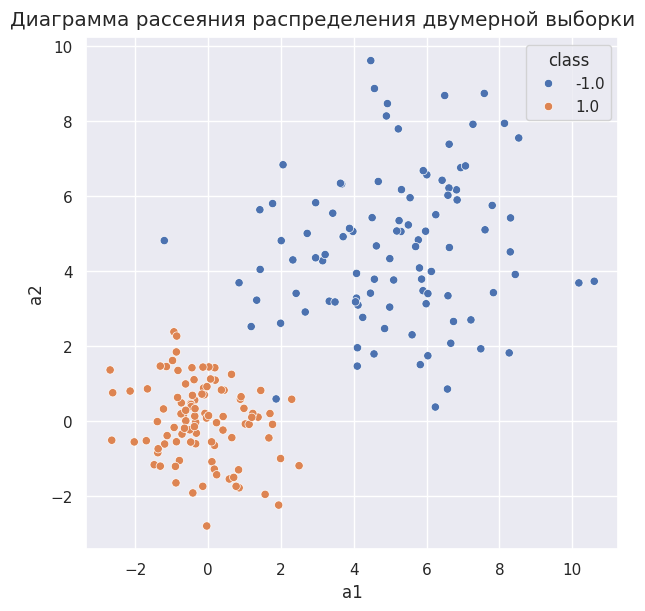

In [36]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True);
fig.suptitle('Диаграмма рассеяния распределения двумерной выборки')

sns.scatterplot(x="x1", y="x2", hue='class', palette=sns.color_palette(), data=df)

ax.set_xlabel('a1')
ax.set_ylabel('a2')

In [37]:
oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')
x0_points = [np.array([10, 10]), np.array([-20, -30])]

In [ ]:
df = get_residual_of_iter_df(oracle, x0_points, method="Newton")

<ipython-input-39-6b3114bd8517>:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
<ipython-input-39-6b3114bd8517>:5: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);


Text(0.5, 1.0, 'x0=[-20, -30]')

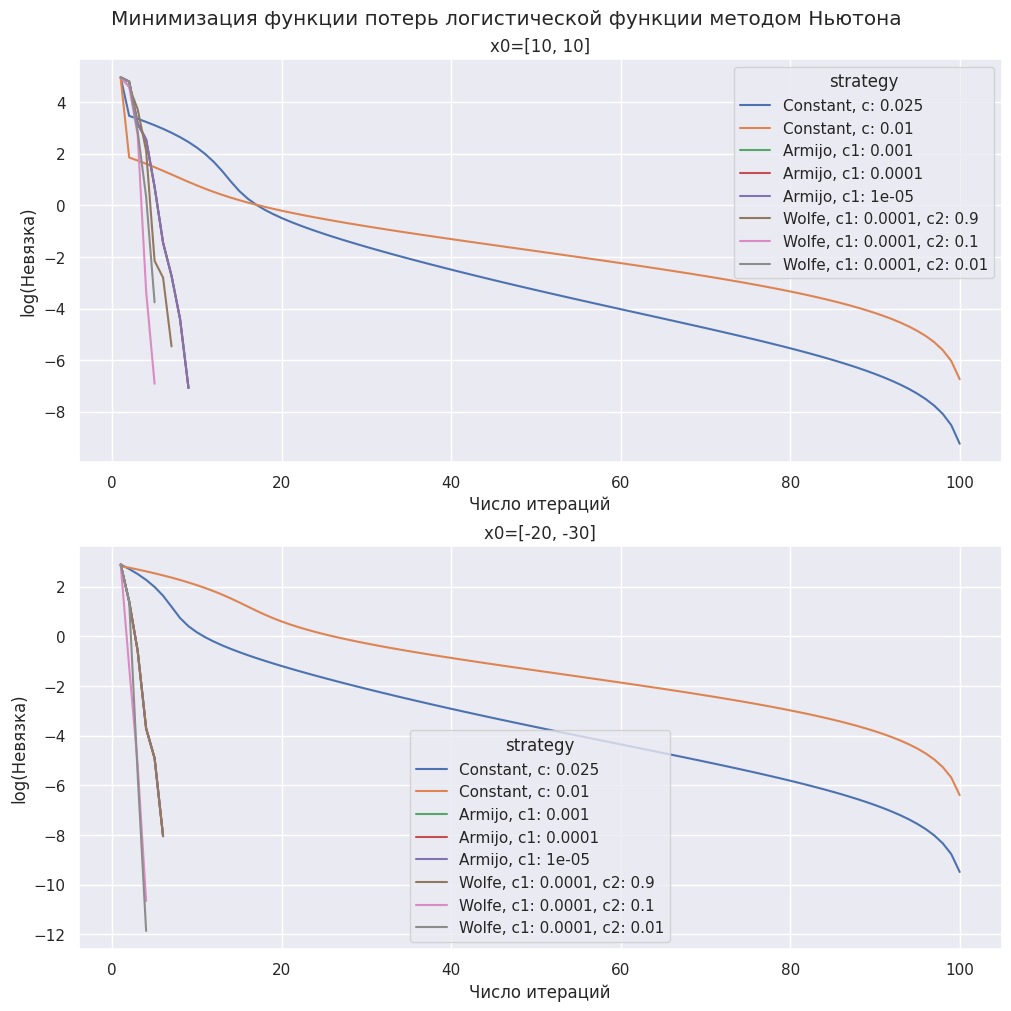

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True);
fig.suptitle('Минимизация функции потерь логистической функции методом Ньютона')

sns.lineplot(ax=axes[0], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[0]);
sns.lineplot(ax=axes[1], x="iterations", y="residual", hue='strategy', palette=sns.color_palette(), data=df[1]);

for i in range(2):
  axes[i].set_xlabel('Число итераций')
  axes[i].set_ylabel('log(Невязка)')

axes[0].set_title(f"x0={list(x0_points[0])}")
axes[1].set_title(f"x0={list(x0_points[1])}")